In [1405]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; 

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [1406]:
df = pd.read_csv('cars_moldova_cat_num (2).csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,40,92,2011,4,195000,1800,2,1,7750,11,17727.272727
1,32,62,2014,11,135000,1500,0,0,8550,8,16875.000000
2,32,71,2012,11,110000,1500,0,0,6550,10,11000.000000
3,28,23,2006,11,200000,1600,3,0,4100,16,12500.000000
4,23,124,2000,5,300000,2200,0,0,3490,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32069,42,88,2016,10,88000,1800,4,1,11500,6,14666.666667
32070,19,53,2002,3,225000,1800,3,0,4400,20,11250.000000
32071,6,77,2015,11,89000,1500,0,0,7000,7,12714.285714
32072,22,10,2006,1,370000,2000,0,0,4000,16,23125.000000


In [1407]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', "km_year_new_Big", "km_year_new_Middle", "km_year_new_Small"]
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

## LinearRegression

In [1408]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

## RidgeRegression

In [1409]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  

In [1410]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


### 4.1 - 4.2 Рассмотрим влияние разных типов предварительной обработки данных на всем датасете

In [1411]:
X,y = df.drop(columns = ['Price(euro)']).values, df['Price(euro)'].values

features_names = df.drop(columns = ['Price(euro)']).columns

X_train, y_train,  X_test, y_test = train_test_split(X, y,  test_size=0.3, )

MinMaxScaler

In [1412]:
scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

Test Score = 0.4751, Train Score = 0.4840


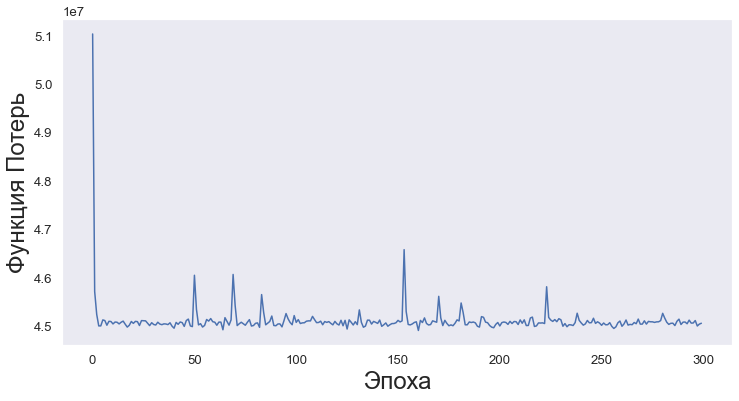

In [1413]:
regr_ = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_.fit(X_train, y_train)
print(f'Test Score = {regr_.score(X_test, y_test):.4f}, Train Score = {regr_.score(X_train, y_train):.4f}')
regr_.plot_cost()

StandardScaler

In [1414]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Test Score = 0.4312, Train Score = 0.4467


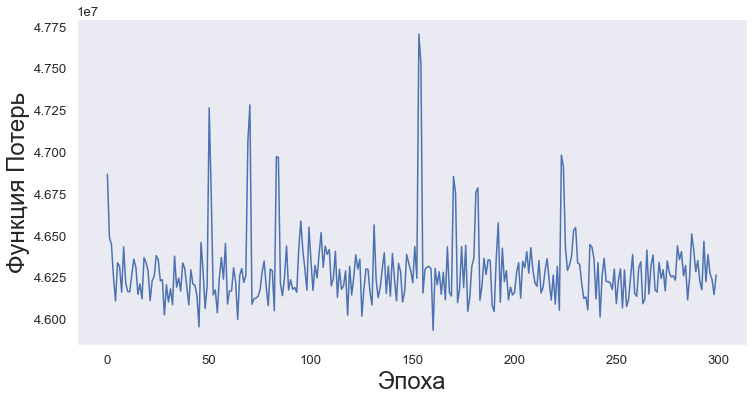

In [1415]:
regr = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr.fit(X_train, y_train)
print(f'Test Score = {regr.score(X_test, y_test):.4f}, Train Score = {regr.score(X_train, y_train):.4f}')
regr.plot_cost()

In [1416]:
w, b = regr_.get_w_and_b()
print(w,b)

[ -1099.95130427    793.3764893   10140.50113862   -738.10593698
 -13645.22832619  25880.83966185   -630.65965548   2792.57424057
 -12891.56933776   6519.65323925] -2750.62784124784


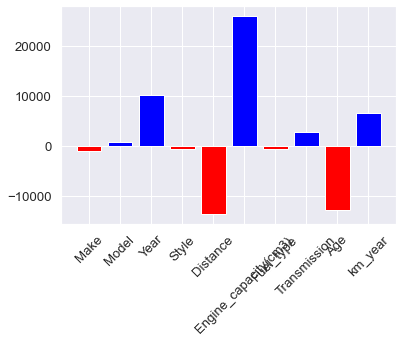

In [1417]:
w, b = regr_.get_w_and_b()

vis_weigths(w, features_names)

Наиболее значимыми признаками являются Year, Distance, Engine_capacity, Age

### Score на тестовой  и обучающей выборке

In [1418]:
df1 = {'Name': ['Linear', 'Linear'], "Scaler": ["MinMaxScaler", "StandardScaler"], 'Score_train': [0.4840, 0.4467], 'Score_test': [0.4751, 0.4312]} 

In [1419]:
df1 = pd.DataFrame(df1) 
df1

,Name,Scaler,Score_train,Score_test
0,Linear,MinMaxScaler,0.4840,0.4751
1,Linear,StandardScaler,0.4467,0.4312


### Матрица корреляции 

Удалим наименее значимые признаки и сравним score

<AxesSubplot:>

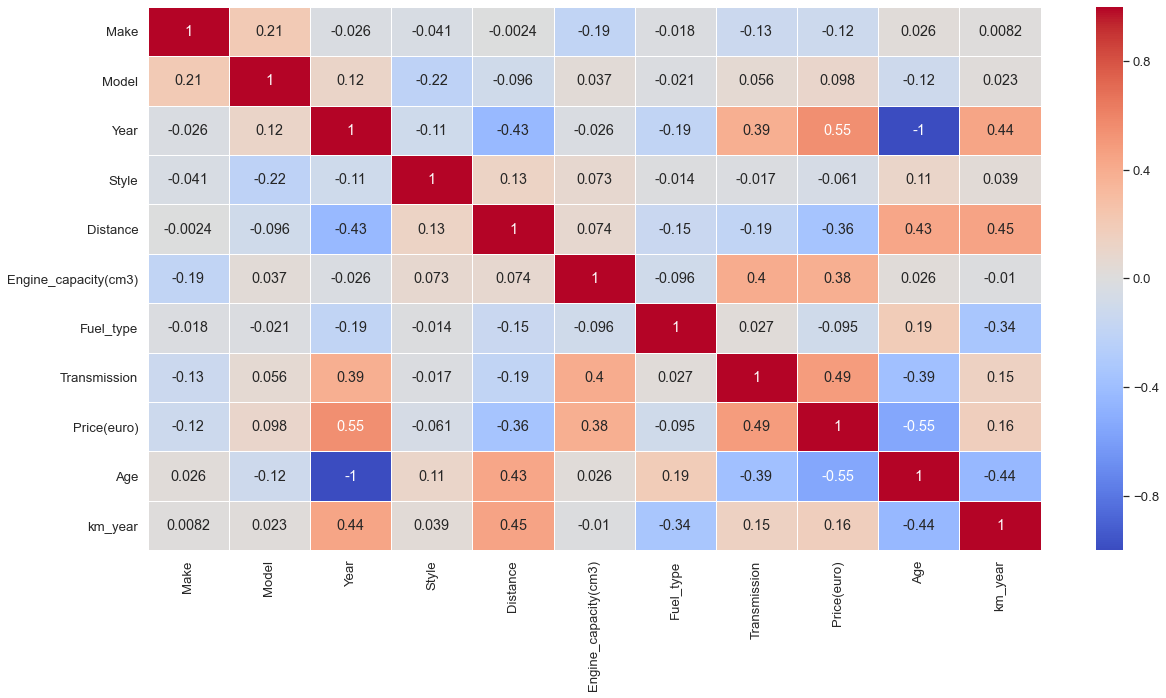

In [1420]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.2)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

Слабая корреляция между тагретом Price и Style

Признаки Year и Age имеют одинаковый смысл, поэтому удалим один из них

In [1421]:
df = df.drop("Year", axis = 1)
df = df.drop("Style", axis=1)

Обучим модель без данных признаков

In [1422]:
X,y = df.drop(columns = ['Price(euro)']).values, df['Price(euro)'].values

features_names = df.drop(columns = ['Price(euro)']).columns

X_train, y_train,  X_test, y_test = train_test_split(X, y,  test_size=0.3, )

In [1423]:
scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test)

Test Score = 0.4936, Train Score = 0.5022


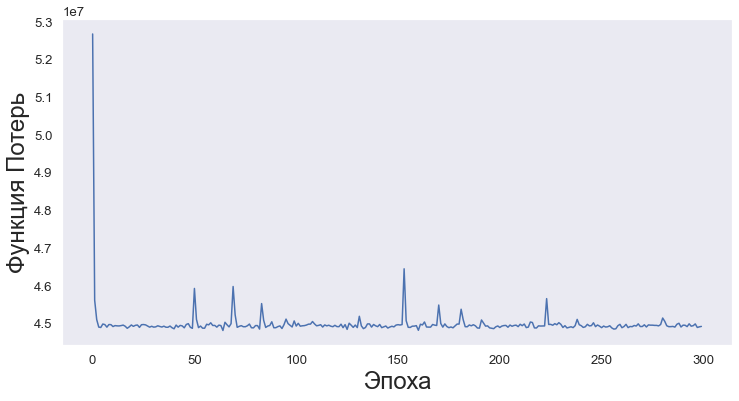

In [1424]:
regr_ = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_.fit(X_train, y_train)
print(f'Test Score = {regr_.score(X_test, y_test):.4f}, Train Score = {regr_.score(X_train, y_train):.4f}')
regr_.plot_cost()

### Score после работы с признаками

In [1425]:
df3 = {'Name': ['Linear', 'Linear'], 'Features': ["with all features", "without some features"], 'Score_train': [0.4840, 0.5022 ], 'Score_test': [0.4751, 0.4936]} 

In [1426]:
df3 = pd.DataFrame(df3) 
df3

,Name,Features,Score_train,Score_test
0,Linear,with all features,0.4840,0.4751
1,Linear,without some features,0.5022,0.4936


## 4.3 Результат модели при использовании только числовых признаков

In [1427]:
num_columns = ['Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year', "Age"]

In [1428]:
from sklearn.model_selection import train_test_split
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32074 entries, 0 to 32073
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Distance              32074 non-null  int64  
 1   Engine_capacity(cm3)  32074 non-null  int64  
 2   Price(euro)           32074 non-null  int64  
 3   km_year               32074 non-null  float64
 4   Age                   32074 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 1.2 MB


### MinMaxScaler

In [1429]:
scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

Посмотрим результат для случаев LinearRegression и RidgeRegression

Test Score = 0.5001, Train Score = 0.4881


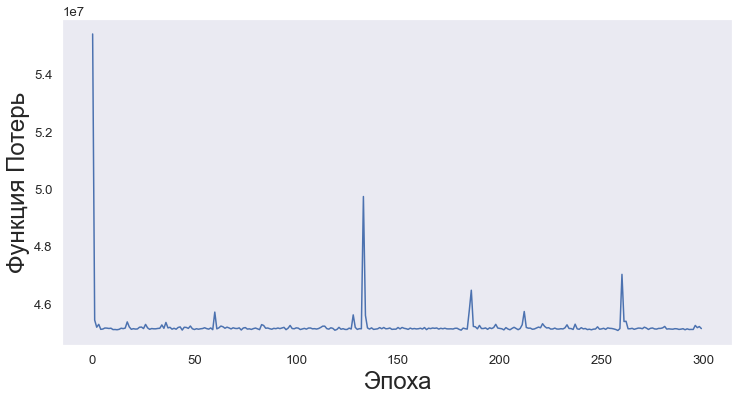

In [1430]:
regr = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr.fit(X_train, y_train)
print(f'Test Score = {regr.score(X_test, y_test):.4f}, Train Score = {regr.score(X_train, y_train):.4f}')
regr.plot_cost()

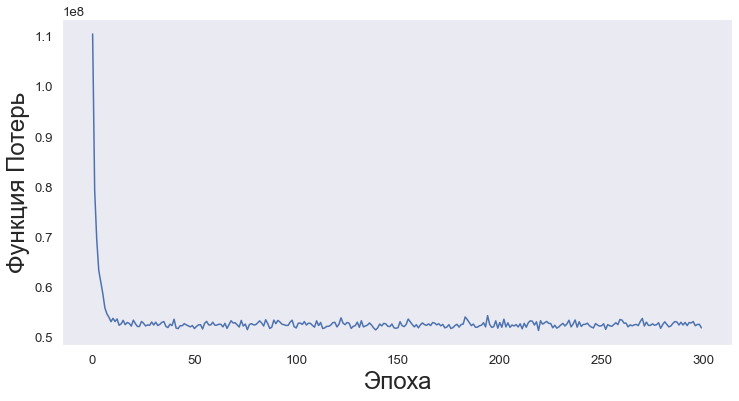

train R2: 0.4882; test R2: 0.5007


In [1431]:
regr = RidgeRegression(learning_rate=0.5,epochs=300,batch_size=3000, l2_penalty = 0.001)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

### StandardScaler

In [1432]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test)

Test Score = 0.4817, Train Score = 0.4665


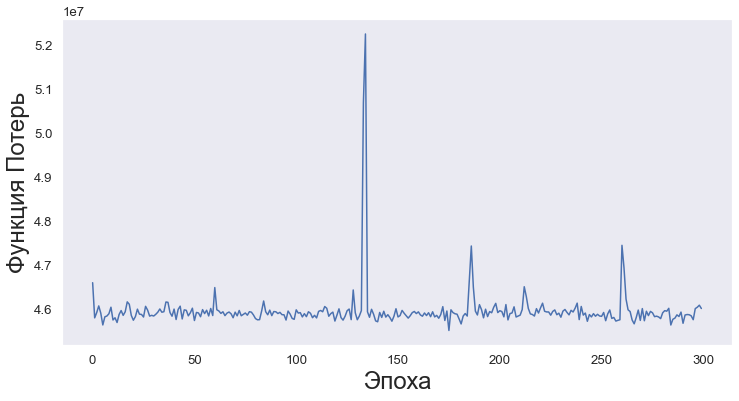

In [1433]:
regr = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr.fit(X_train, y_train)
print(f'Test Score = {regr.score(X_test, y_test):.4f}, Train Score = {regr.score(X_train, y_train):.4f}')
regr.plot_cost()

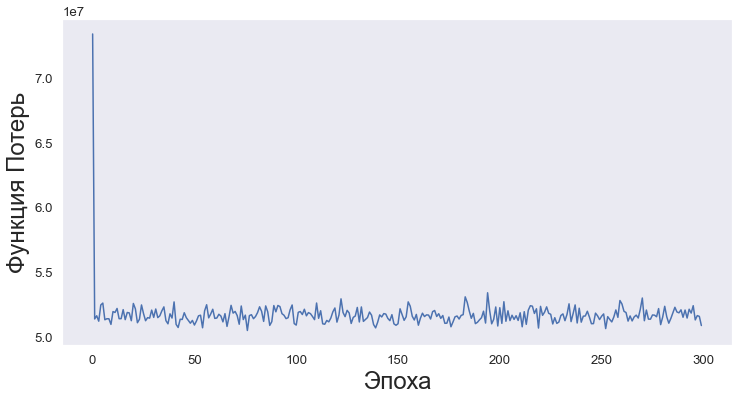

train R2: 0.4866; test R2: 0.4958


In [1434]:
regr = RidgeRegression(learning_rate=0.5,epochs=300,batch_size=3000, l2_penalty = 0.001)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

### Результат

In [1435]:
df3 = {'Name': ['Linear', 'Ridge', 'Linear', 'Ridge'], "Scaler": ["MinMaxScaler","MinMaxScaler","StandardScaler", "StandardScaler"], 'Score_train': [0.4881,  0.4882, 0.4665, 0.4866], 'Score_test': [0.5001, 0.5007, 0.4817, 0.4958]} 

In [1436]:
df3 = pd.DataFrame(df3) 
df3

,Name,Scaler,Score_train,Score_test
0,Linear,MinMaxScaler,0.4881,0.5001
1,Ridge,MinMaxScaler,0.4882,0.5007
2,Linear,StandardScaler,0.4665,0.4817
3,Ridge,StandardScaler,0.4866,0.4958


## Рассмотрим результат на численных и категориальных признаках

Добавим категориальный признак из предыдущего домашнего задания

In [1437]:
# Рассчитаем 0.75-квантиль и 0.25-квантиль
q75 = int(np.quantile(df['km_year'], 0.75))
q25 = int(np.quantile(df['km_year'], 0.25))
q25, q75

(10250, 18800)

In [1438]:
# Создадим новый столбец в который в будущем запишем категории пробега
df["km_year_new"] = df["km_year"]

In [1439]:
# Сделаем соответствующую замену на небольшой, средний и большой пробеги
df["km_year_new"] = df["km_year_new"].apply(lambda x: (int(x) >= q75 and "Big") or (int(x) < q25 and "Small") or "Middle") 

In [1440]:
# Сделаем One Hot Encoding
df = pd.get_dummies(df, columns=['km_year_new'])
df.head(5)

,Make,Model,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,km_year_new_Big,km_year_new_Middle,km_year_new_Small
0,40,92,195000,1800,2,1,7750,11,17727.272727,0,1,0
1,32,62,135000,1500,0,0,8550,8,16875.000000,0,1,0
2,32,71,110000,1500,0,0,6550,10,11000.000000,0,1,0
3,28,23,200000,1600,3,0,4100,16,12500.000000,0,1,0
4,23,124,300000,2200,0,0,3490,22,13636.363636,0,1,0


In [1441]:
# Сделаем One Hot Encoding для категориальных признаков 
df = pd.get_dummies(df, columns=['Age','Transmission','Make'])
df = df.drop("km_year", axis=1)
df.head(5)

,Model,Distance,Engine_capacity(cm3),Fuel_type,Price(euro),km_year_new_Big,km_year_new_Middle,km_year_new_Small,Age_1,Age_2,...,Make_34,Make_35,Make_36,Make_37,Make_38,Make_39,Make_40,Make_41,Make_42,Make_43
0,92,195000,1800,2,7750,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,62,135000,1500,0,8550,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,71,110000,1500,0,6550,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,200000,1600,3,4100,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,124,300000,2200,0,3490,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1442]:
X,y = df.drop(columns = ['Price(euro)']).values,df['Price(euro)'].values

features_names = df.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### MinMaxScaler

In [1443]:
scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

Test Score = 0.6480, Train Score = 0.6500


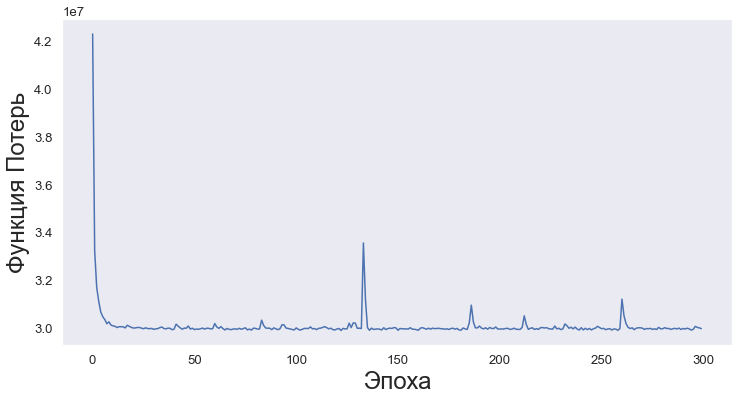

In [1444]:
regr = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr.fit(X_train, y_train)
print(f'Test Score = {regr.score(X_test, y_test):.4f}, Train Score = {regr.score(X_train, y_train):.4f}')
regr.plot_cost()

#### При добавлении категориальных признаков с помощью one-hot кодирования score увеличился с 0.4936 до 0.6500

### 4.4 Наиболее значимые признаки для случая с one hot encoding

In [1445]:
w_new = pd.Series(w)
res = w_new.nlargest(10)
print(res)
features_names_ = features_names[res.index]
features_names_

5    25880.839662
2    10140.501139
9     6519.653239
7     2792.574241
1      793.376489
6     -630.659655
3     -738.105937
0    -1099.951304
8   -12891.569338
4   -13645.228326
dtype: float64


Index(['km_year_new_Middle', 'Engine_capacity(cm3)', 'Age_3', 'Age_1',
       'Distance', 'km_year_new_Small', 'Fuel_type', 'Model', 'Age_2',
       'km_year_new_Big'],
      dtype='object')

In [1446]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 );

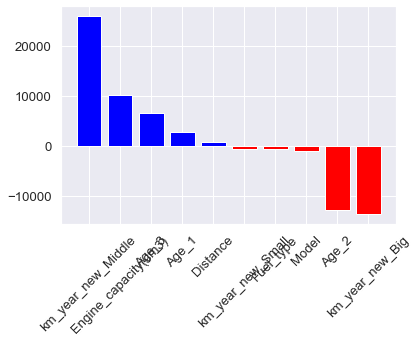

In [1447]:
vis_weigths(res, features_names_)

Наиболее значимые признаки относятся к таким категориям как Age, km_year